In [1]:
#!pip install --upgrade tensorflow==1.15

In [2]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import array as arr


In [3]:
# Load a CSV file
def load_csv(filename):
	dataset = list()*10
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
			y_test.append(row[-1])	
	return dataset

In [4]:
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

In [5]:
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()*10
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats

In [6]:
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [7]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()*10
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()*10
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

In [8]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [9]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()*10
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()*10
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

In [10]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()*10
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

In [11]:
from math import exp
 
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation
 
# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))
 
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []*10
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs
 

In [12]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)
 
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()*10
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [13]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['delta']

In [14]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)

In [15]:
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))
 
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	pred = list()*10
	for row in test:
		prediction = predict(network, row)
		pred.append(prediction)
		y_pred.append(prediction)
	return(pred)

In [16]:
# Test Backprop on Seeds dataset
seed(2)
# load and prepare data
filename = 'Train_DL1.csv'
y_pred = []*10
y_test = []*10
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_int(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.2
n_epoch = 10
n_hidden = 2
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))


Scores: [80.13877829598452, 81.03742463883518, 80.93504720737118, 81.26493004208851, 81.4355590945285]
Mean Accuracy: 80.962%


In [17]:
y_pred

[1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [18]:
y_test

['income_>50K',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',


In [19]:
y_test.pop(0)

'income_>50K'

In [20]:
len(y_test)

43957

In [21]:
len(y_pred)

43955

In [22]:
y_test = map(int, y_test)
y_test = list(y_test)
y_test

[1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,


In [26]:
from sklearn.metrics import classification_report
matrix = classification_report(y_test,y_pred)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.80      0.78     33437
           1       0.24      0.20      0.21     10518

    accuracy                           0.65     43955
   macro avg       0.50      0.50      0.50     43955
weighted avg       0.63      0.65      0.64     43955



<function matplotlib.pyplot.show>

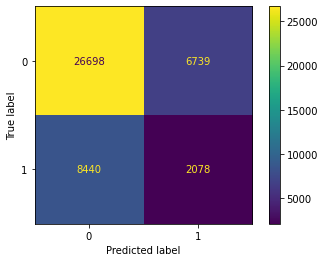

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show

In [28]:
import pandas as pd
df = pd.read_csv('Train_DL1.csv')
df.drop(labels=['race','workclass','fnlwgt','education','marital-status','occupation','relationship','gender','capital-gain','capital-loss','native-country'],axis=1, inplace=True)
df

,age,educational-num,hours-per-week,income_>50K
0,67,16,60,1
1,17,8,15,0
2,31,13,40,1
3,58,4,40,0
4,25,10,40,0
...,...,...,...,...
43952,52,13,50,1
43953,19,9,40,0
43954,30,10,58,0
43955,46,13,35,0


In [29]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
df = pd.read_csv('Train_DL1.csv')
x = df[['educational-num', 'hours-per-week', 'income_>50K']]
y = df[['age']]
parameter_range = np.arange(1, 20, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), x, y, param_name = "n_neighbors", param_range = parameter_range, cv = 5, scoring = "accuracy")
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist

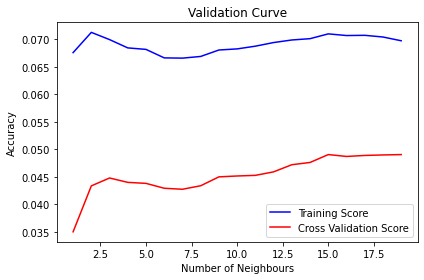

In [30]:
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'blue')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'red')
plt.title("Validation Curve")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()